<img src='sharif_logo.png' alt="SUT logo" width=150 height=150 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
 Deep Learning <br>
<font color=2565AE size=5>
Mathematical Sciences Department - Spring 2025  <br>
<font color=3C99D size=5>
          Homework 1: Practical - PINN for Coupled Spring-Mass System <br>
<font color=696880 size=4>
            Designer: Shaygan Adim
    
    

**Name**:  "masoud mozafari"
  
**Student Code**: 400107383

# Overview  

In this assignment, you will design and implement a Physics-Informed Neural Network (PINN) to solve the equations of motion for a system of coupled masses connected by springs. The goal is to leverage the power of neural networks to approximate the solutions to differential equations that describe physical systems, by incorporating known physical laws into the training process.  
It's highly recommended to do some research on PINN (especially for solving PDEs and ODEs) before starting.

# Objectives  
* Implement a PINN to solve the system of differential equations governing a coupled mass-spring system.
* Understand how to embed differential equations into the loss function of a neural network.
* Compare the neural network's predictions with solutions obtained from a high-precision ODE solver.
* Visualize the training process and results through plots and charts.

# What is a Physics-Informed Neural Network (PINN)?  
A **Physics-Informed Neural Network (PINN)** is a type of neural network that incorporates known physical laws, expressed as differential equations, into the learning process. Instead of relying solely on data to learn the underlying patterns, PINNs leverage the governing equations of the physical system to inform and constrain the neural network's predictions.  
Traditional neural networks require large datasets to learn accurate mappings from inputs to outputs. However, in many scientific and engineering applications, collecting sufficient data can be challenging. Additionally, physical systems are governed by well-established laws expressed as differential equations.  
  
In PINNs, the physical laws are incorporated into the loss function used during training. The loss function typically consists of multiple components:

* Physics-Informed Loss (Residual Loss):

    * This loss measures how well the neural network's predictions satisfy the differential equations describing the physical system.
It is computed by substituting the network's outputs (and their derivatives) into the differential equations and calculating the residual (the difference between the left-hand side and the right-hand side of the equations).
The residuals are expected to be close to zero if the network's predictions satisfy the equations.  
  
* Initial and Boundary Condition Loss:

    * Ensures that the network's predictions adhere to the known initial and boundary conditions of the problem.
Calculated as the difference between the network's predictions and the specified conditions at certain points.  
  
* Data Loss (if ground truth data were available which is not in our case):

    * Measures the discrepancy between the network's predictions and any available observed data.
Used when some ground truth data is available to guide the training process.
The total loss is a combination of these components, and minimizing it during training encourages the network to produce solutions that both fit any available data and respect the underlying physics.

**Automatic Differentiation**  
A key aspect of PINNs is the use of automatic differentiation provided by deep learning frameworks like PyTorch or TensorFlow. Automatic differentiation allows for efficient and exact computation of derivatives of the network's outputs with respect to its inputs, which is essential for evaluating the differential equations in the physics-informed loss.

# How Are We Using PINNs in Our Assignment?  
We are solving the equations of motion for a chain of masses connected by springs. The system is governed by second-order ordinary differential equations (ODEs) that describe how the position of each mass evolves over time based on its neighboring masses.  
In our case, we want to measure the power of PINNs when ground truth data is not available but the physics laws are known. Thus, we will use physics-informed loss and initial condition loss.

# Physical System Description  
**Mass-Spring System**:  
  
<img src="system.png" alt="" width="900" height="400">  
  
As you can see in the image, We consider a linear chain of **N** point masses connected by identical springs. The motion of each mass is influenced by its neighboring masses through the spring forces.  
  
**Equations of Motion**  

The differential equations describing the system are simply newton 2nd law for each mass:  
  
<img src="equations.png" alt="" width="900" height="400">  
  
where:    
  
* $x_i(t)$ is the position of the $i$-th mass at time $t$.

* $\ddot{x}_i$ is the acceleration of the $i$-th mass.

* $\alpha = \frac{k}{m}$ is a constant, with $k$ being the spring constant and $m$ the mass.  
  
**Initial Conditions**  
  
Initial Positions:  
All masses start from position zero, except the first mass, which starts from position $-x_0$ to ensure numerical stability.


$x_i(0) =
\begin{cases} 
-x_0, & \text{for } i = 1 \\
0, & \text{for } i > 1 
\end{cases}
$

Initial Velocities:  
All masses have zero initial velocity.

$
\dot{x}_i(0) = 0, \quad \text{for all } i
$
  
Keep in mind that we want to solve the equations for $0<t<T$

# Model architecture  
Our neural network's architecture is a simple feed-forward structure designed to approximate the function $x_i(t)$, mapping time $t$ to the positions of the masses.

### Input and Output

- **Input:** Time $t$.
- **Output:** Positions $x = (x_1(t), x_2(t), \ldots, x_N(t))$.

# Some notes:

* Using ChatGPT and other LLMs are allowed but you should be able to explain every line of your code completely.
* You might need GPU for this assignment. Use can use Colab or Kaggle for free.
* I highly recommend using the exact same structure and instructions that is provided for you in the notebook but minor changes will be tolerated.
* Read the whole notebook once before coding. It will give you a broad vision about what you should do on the whole.
* Instructions provided for you in TODO sections ARE NOT the only things that you should do in those parts. They're just some important bullet points that your code should have.
* The final results' quality should resemble the quality of the notebook results itself.

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from tqdm import tqdm

# System configuration

In [2]:
N = 3  # Number of masses
alpha = 1.0  # Constant α = k/m
T = 10.0  # Total time
epsilon = 0.1  # Small value for initial condition time window
x0 = 1.0  # Initial displacement of the first mass

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Data generation (10 Points)
In this section we'll generate uniform data points for $0<t<T$ to train the model.  
We also need to append some additional initial time ($t=0$) data for the model to learn initial conditions better.

In [3]:
# Sample points should be uniformly distributed between 0 and T

num_train = 20000  # Number of training samples
num_val = 1000  # Number of validation samples

t_train = np.linspace(0, T, num_train)
t_val = np.linspace(0, T, num_val)

num_init = 1000

t_init = np.linspace(0, epsilon, num_init)
t_train = np.concatenate((t_train, t_init))

In [4]:
t_train_tensor = torch.tensor(t_train.reshape(-1, 1), dtype=torch.float32, requires_grad=True).to(device)
t_val_tensor = torch.tensor(t_val.reshape(-1, 1), dtype=torch.float32, requires_grad=True).to(device)

# Model (25 Points)
In this section you need to implement the PINN and create an instance of it.

In [5]:
class PINN(nn.Module):
    def __init__(self, num_masses: int, num_hidden_layers: int = 4, num_neurons: int = 64):
        super(PINN, self).__init__()
        # The network should take time t (dimension 1) as input and output 
        # the positions of all masses (dimension num_masses)
        # Add a non-linear activation (Tanh is recommended for PINNs)
        
        layers = []
        input_size = 1
        
        for h in range(num_hidden_layers):
            layers.append(nn.Linear(input_size, num_neurons))
            layers.append(nn.Tanh())
            input_size = num_neurons
            
        layers.append(nn.Linear(input_size, num_masses))
            
        self.model = nn.Sequential(*layers)

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        # Return the output of the model given the time input t
        return self.model(t)


model = PINN(num_masses=N, num_hidden_layers=4, num_neurons=64).to(device)

# Custom Loss (30 Points) 
In this section you need to implement the custom loss for the PINN.

In [6]:
def physics_informed_loss(model: nn.Module, t: torch.Tensor) -> torch.Tensor:
    # Enable gradient tracking for t
    t.requires_grad_(True)
    
    # Forward pass to get positions
    x = model(t)
    
    # Initialize tensors to hold first and second derivatives
    x_t = torch.zeros_like(x)
    x_tt = torch.zeros_like(x)
    
    # For each mass (each output of the neural network):
    # 1. Calculate the first derivative
    # 2. Calculate the second derivative
    # 3. Store these derivatives in x_t and x_tt
    for i in range(N):
        grad_i = torch.autograd.grad(x[:, i].sum(), t, create_graph=True)[0]
        x_t[:, i] = grad_i.squeeze()
        
        grad_ii = torch.autograd.grad(grad_i.sum(), t, create_graph=True)[0]
        x_tt[:, i] = grad_ii.squeeze()


    residuals = torch.zeros_like(x)

    for i in range(N):
        if i==0:
            residuals[:, 0] = x_tt[:, 0] - alpha * (x[:, 1] - 2.0 * x[:, 0])
        elif i==N-1:
            residuals[:, i] = x_tt[:, i] - alpha * (x[:, i-1] - 2.0 * x[:, i])
        else:
            residuals[:, i] = x_tt[:, i] - alpha * (x[:, i-1] - 2.0 * x[:, i] + x[:, i+1])
        
    loss_phys = torch.mean(residuals**2)
    
    return loss_phys

In [7]:
def initial_condition_loss(model: nn.Module, t: torch.Tensor) -> torch.Tensor:
    t.requires_grad_(True)
    
    # Forward pass to get positions
    x = model(t)
    
    # Initialize tensor to hold first derivatives (velocities)
    x_t = torch.zeros_like(x)

    for i in range(N):
        grad_i = torch.autograd.grad(x[:, i].sum(), t, create_graph=True)[0]
        x_t[:, i] = grad_i.squeeze()
    
    x0_pred = x[0]
    v0_pred = x_t[0]
    
    desired_pos = torch.zeros_like(x0_pred)
    desired_pos[0] = -x0
    
    desired_vel = torch.zeros_like(v0_pred)
    
    loss_pos = torch.mean((x0_pred - desired_pos) ** 2)
    loss_vel = torch.mean((v0_pred - desired_vel) ** 2)
    
    loss_ic = loss_pos + loss_vel
    
    return loss_ic

# Training (20 Points)
Train the model at least 3000 epochs. Also save train and validation loss every few epochs and plot it afterwards.

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 6000  # Adjust as needed

In [12]:
# Initialize lists to track training progress
loss_history = []
val_loss_history = []
epochs = []

for epoch in tqdm(range(num_epochs)):
    model.train()

    loss_pde = physics_informed_loss(model, t_train_tensor)
    loss_ic = initial_condition_loss(model, t_train_tensor)
    
    loss = loss_pde + loss_ic
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Record training loss
    loss_history.append(loss.item())
    
    if (epoch + 1) % 500 == 0 or epoch == 0:
        # Set model to evaluation mode
        model.eval()


        val_loss_pde = physics_informed_loss(model, t_val_tensor)
        val_loss_ic = initial_condition_loss(model, t_val_tensor)
        val_loss = val_loss_pde + val_loss_ic

        val_loss_history.append(val_loss.item())
        epochs.append(epoch + 1)
        
        tqdm.write(
            f"Epoch [{epoch + 1}/{num_epochs}] | Train Loss: {loss.item():.6f} | Val Loss: {val_loss.item():.6f}"
        )
        

  0%|          | 3/6000 [00:00<08:09, 12.25it/s]

Epoch [1/6000] | Train Loss: 0.017097 | Val Loss: 0.509734


  8%|▊         | 504/6000 [00:21<04:00, 22.89it/s]

Epoch [500/6000] | Train Loss: 0.016799 | Val Loss: 0.017564


 17%|█▋        | 1002/6000 [00:43<03:55, 21.19it/s]

Epoch [1000/6000] | Train Loss: 0.016216 | Val Loss: 0.016957


 25%|██▌       | 1503/6000 [01:05<03:07, 23.94it/s]

Epoch [1500/6000] | Train Loss: 0.013053 | Val Loss: 0.013646


 33%|███▎      | 2004/6000 [01:27<03:05, 21.50it/s]

Epoch [2000/6000] | Train Loss: 0.008097 | Val Loss: 0.008455


 42%|████▏     | 2505/6000 [01:48<02:19, 24.97it/s]

Epoch [2500/6000] | Train Loss: 0.005762 | Val Loss: 0.006301


 50%|█████     | 3003/6000 [02:08<02:12, 22.63it/s]

Epoch [3000/6000] | Train Loss: 0.003445 | Val Loss: 0.003613


 58%|█████▊    | 3504/6000 [02:29<01:44, 23.83it/s]

Epoch [3500/6000] | Train Loss: 0.002608 | Val Loss: 0.002739


 67%|██████▋   | 4003/6000 [02:57<01:52, 17.83it/s]

Epoch [4000/6000] | Train Loss: 0.001425 | Val Loss: 0.001504


 75%|███████▌  | 4503/6000 [03:25<01:22, 18.19it/s]

Epoch [4500/6000] | Train Loss: 0.000718 | Val Loss: 0.000786


 83%|████████▎ | 5003/6000 [03:53<00:54, 18.28it/s]

Epoch [5000/6000] | Train Loss: 0.000367 | Val Loss: 0.000392


 92%|█████████▏| 5503/6000 [04:20<00:27, 18.39it/s]

Epoch [5500/6000] | Train Loss: 0.000215 | Val Loss: 0.000231


100%|██████████| 6000/6000 [04:47<00:00, 20.85it/s]

Epoch [6000/6000] | Train Loss: 0.000451 | Val Loss: 0.000347


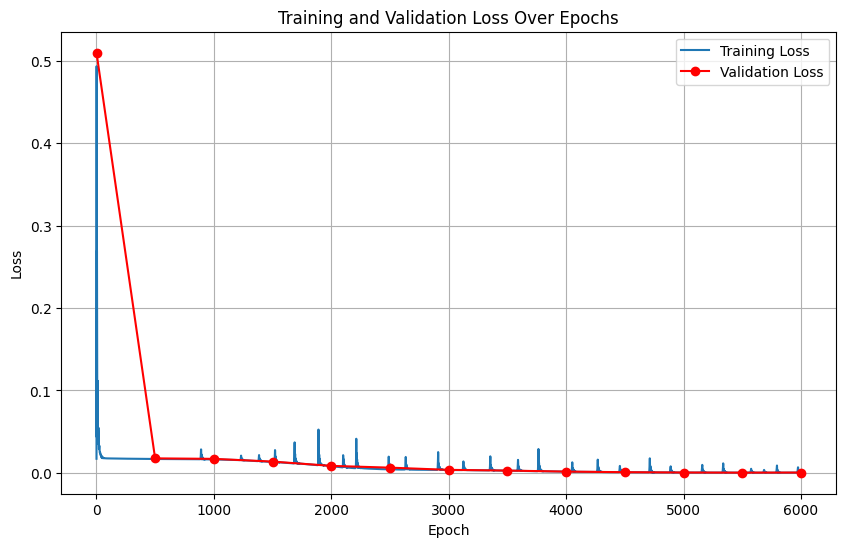

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_history, label='Training Loss')

plt.plot(epochs, val_loss_history, 'ro-', label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation (15 Points)
In this section you need to solve the system using a automatic ODE solver and compare the PINN predictions with the ODE solver results.  
We will use scipy solve_ivp. Do a bit of a research on it and then code this section.

In [14]:
def mass_spring_system(t, y):
    dydt = np.zeros(N * 2)
    x = y[:N]
    v = y[N:]

    for i in range(N):
        if i == 0:
            a = alpha * (x[1] - 2 * x[0])
        elif i == N - 1:
            a = alpha * (x[N - 2] - 2 * x[N - 1])
        else:
            a = alpha * (x[i - 1] - 2 * x[i] + x[i + 1])
        dydt[i] = v[i]
        dydt[N + i] = a
    return dydt

In [15]:
# Initial Conditions for ODE Solver
x_init = np.zeros(N)
x_init[0] = -x0
v_init = np.zeros(N)
y0 = np.concatenate((x_init, v_init))

In [16]:
solution = solve_ivp(mass_spring_system, (0, T), y0, t_eval=t_val, method='RK45')

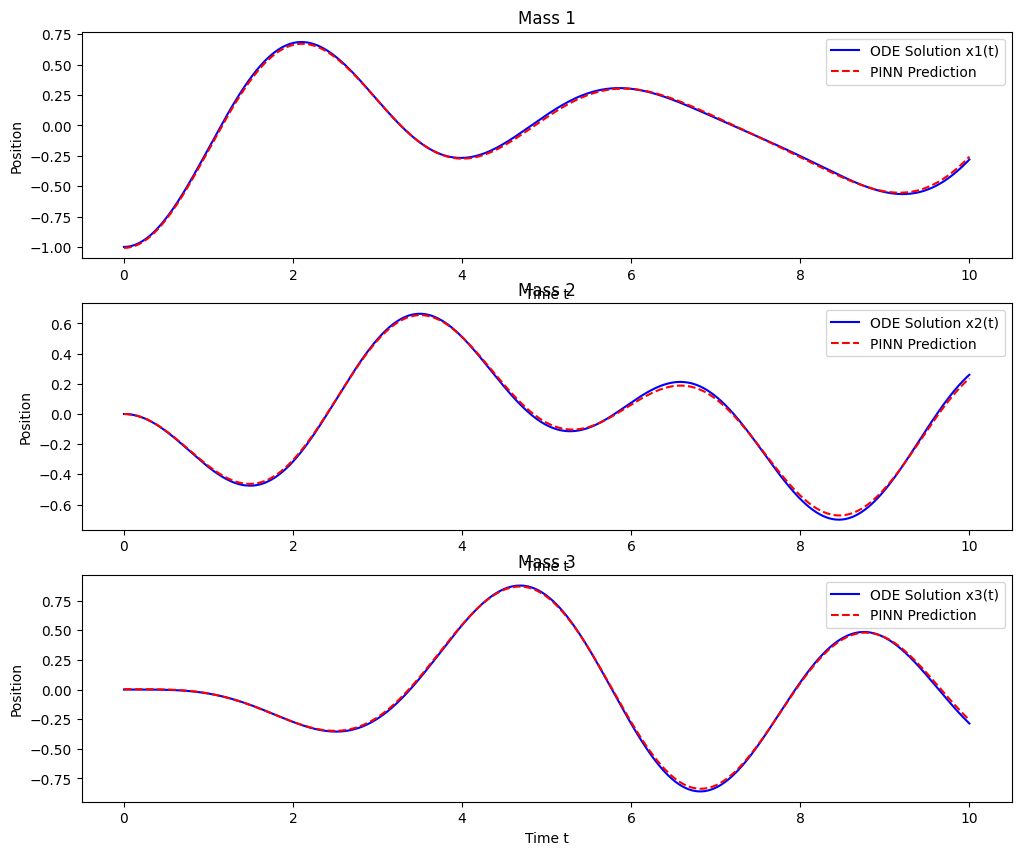

In [17]:
solution_pinn = model.forward(t_val_tensor)
solution_pinn = solution_pinn.cpu().detach().numpy()

plt.figure(figsize=(12, 10))

for i in range(N):
    ax = plt.subplot(N, 1, i + 1)
    ax.plot(solution.t, solution.y[i, :], 'b-', label=f"ODE Solution x{i+1}(t)")
    ax.plot(t_val, solution_pinn[:, i], 'r--', label="PINN Prediction")
    ax.set_title(f"Mass {i + 1}")
    ax.set_xlabel("Time t")
    ax.set_ylabel("Position")
    ax.legend()


# Enjoy the beauty!